In [1]:
!pip install requests pandas networkx matplotlib

'/f' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Etude de la base de données représentant MAVEN

#### Setup


-- > Installer NE4OJ (site : https://neo4j.com/docs/operations-manual/4.4/installation/windows/)

- Install java 11 : https://www.oracle.com/java/technologies/downloads/?er=221886#java11  
    - Extrayez l'archive téléchargée
    - Configurez la variable d'environnement JAVA_HOME pour pointer vers le répertoire extrait.
    - Ajoutez le chemin bin du répertoire java à la variable PATH.

- Install neo4j v4.4 (version : neo4j-community-4.4.38-windows) : https://neo4j.com/deployment-center/  dans Graph Database 
Self-Managed -> Communty et choisir version v4.4
    - Extrayez l'archive téléchargée
    - Configurez la variable d'environnement NEO4J_HOME pour pointer vers le répertoire extrait.
    - Ajoutez le chemin bin du répertoire à la variable PATH.

- Mettez changer le password de la base (exemple) :
    - neo4j-admin set-initial-password <password> --require-password-change
        - user = neo4j
        - pwd = base

- Télécharger la base de données (graph)
    - DL la base de données "goblin_maven_30_08_24.dump" (à dl ici: https://zenodo.org/records/10291589)
    - neo4j-admin load --from=[schemin vers le fichier dum] --database=neo4j --force

- RUN 
    - Exécuter ces commandes : 
        - $env:JAVA_HOME= [Schemin vers java 11]
        - $env:PATH="$env:JAVA_HOME\bin;$env:PATH"
        - neo4j start 
        - Allez sur l'adresse local indiqué pour voir si ça marche

--> Goblin

- Install java 17 : https://www.oracle.com/java/technologies/downloads/?er=221886#java17
    - Extrayez l'archive téléchargée
    - Configurez la variable d'environnement JAVA_HOME pour pointer vers le répertoire extrait.
    - Ajoutez le chemin bin du répertoire java à la variable PATH.

- Télécharger le fichier goblinWeaver-1.0.0.jar (dans le dossier sinon à dl ici : https://zenodo.org/records/10291589)

- RUN 
    - $env:JAVA_HOME=[Schemin vers java 17]
    - $env:PATH="$env:JAVA_HOME\bin;$env:PATH
    - java -Dneo4jUri="bolt://localhost:7687" -Dneo4jUser="neo4j" -Dneo4jPassword="base" -jar goblinWeaver-1.0.0.jar
    - use : noUpdate argument if already run once
    - Aller sur : http://localhost:8080/swagger-ui/index.html


### Comprendre les outils

#### Neo4j
- Neo4j est une base de données sours forme de GRAPH. 
- Il faut utiliser des requêtes CYPHER pour communiquer avec la base

#### Goblin
- Goblin est un intermédiaire entre vous et la base neo4j. 
- Elle permet d'ajouter des valeurs tels que CVE à une requête pour récupérer des infos suppélementaires
- On communique avec l'outil via des requête à l'url qu'elle met en place, lorsqu'on la run (http://localhost:8080/cypher)

#### Exemple de requête


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url = "http://localhost:8080/cypher"
headers = {"Content-Type": "application/json"}

In [4]:
def post_query(query):
    
    response = requests.post(url, headers=headers, json=query)
    
    if response.status_code == 200:
        return response.json()
    else:
        print("Erreur :", response.text)

Exemple que query CYPHER pour retourner 10 noeuds 

In [ ]:
query = {
    "query": "MATCH (n) RETURN n LIMIT 10",
    "addedValues": ["CVE"]
}

reponse  = post_query(query)
print(reponse)

[{'node': {'elementId': '0', 'found': True, 'id': 'com.splendo.kaluga:alerts-androidlib', 'labels': ['Artifact']}}, {'node': {'elementId': '1', 'found': True, 'id': 'org.wso2.carbon.identity.framework:org.wso2.carbon.identity.cors.mgt.core', 'labels': ['Artifact']}}, {'node': {'elementId': '2', 'found': True, 'id': 'org.apache.camel.quarkus:camel-quarkus-kotlin-parent', 'labels': ['Artifact']}}, {'node': {'elementId': '3', 'id': 'org.wso2.carbon.identity.framework:org.wso2.carbon.identity.cors.mgt.core:5.20.111', 'CVE': [], 'version': '5.20.111', 'timestamp': 1626148242000, 'labels': ['Release']}}, {'node': {'elementId': '4', 'id': 'org.apache.camel.quarkus:camel-quarkus-kotlin-parent:1.0.0-M4', 'CVE': [], 'version': '1.0.0-M4', 'timestamp': 1583239943000, 'labels': ['Release']}}, {'node': {'elementId': '5', 'id': 'org.apache.camel.quarkus:camel-quarkus-kotlin-parent:1.0.0-M3', 'CVE': [], 'version': '1.0.0-M3', 'timestamp': 1579861029000, 'labels': ['Release']}}, {'node': {'elementId':

### Sujet :

Objective : 

Investigate the clustering patterns within the Maven Central dependency graph to identify distinct clusters and assess their interactions, with a focus on detecting high-risk clusters that could impact ecosystem stability.

Research Questions :

1 -  Can we deduce different clusters from Maven Central’s comprehensive dependency graph? How do these clusters interact with one another?

2 - How can clustering be used to identify high-risk clusters in the Maven Central ecosystem?


### 1/ Comprendre le graphe


Types de noeuds 

In [6]:
query = {
    "query": """
            MATCH (n)
            RETURN labels(n) AS labels, COUNT(*) AS count
    """,
    "addedValues": []
}

# reponse = post_query(query)
# print(reponse)

Il y a 2 types de noeuds : 

- 658078 noeuds Artifact

- 14459139 noeuds Release

Types de relations

In [7]:
query = {
    "query": """
        MATCH ()-[r]->()
        RETURN type(r) AS relation_type, COUNT(*) AS count

    """,
    "addedValues": []
}

#reponse = post_query(query)
# print(reponse)

Il y a 2 types de relations : 

- 14459139 liens relationship_AR

- 119660406 noeuds dependency

Echantillon

In [8]:
query = {
    "query": """
        MATCH (a)-[r]->(b)
        RETURN a, r, b LIMIT 10

    """,
    "addedValues": []
}

reponse = post_query(query)
print(reponse)

[{'node': {'elementId': '14551269', 'id': 'com.splendo.kaluga:alerts-androidlib:1.4.0', 'version': '1.4.0', 'timestamp': 1718120613000, 'labels': ['Release']}, 'relationship': {'sourceElementId': '0', 'targetElementId': '14551269', 'type': 'relationship_AR'}}, {'node': {'elementId': '13409270', 'id': 'com.splendo.kaluga:alerts-androidlib:1.3.1', 'version': '1.3.1', 'timestamp': 1702996551000, 'labels': ['Release']}, 'relationship': {'sourceElementId': '0', 'targetElementId': '13409270', 'type': 'relationship_AR'}}, {'node': {'elementId': '13409269', 'id': 'com.splendo.kaluga:alerts-androidlib:1.3.0', 'version': '1.3.0', 'timestamp': 1699642766000, 'labels': ['Release']}, 'relationship': {'sourceElementId': '0', 'targetElementId': '13409269', 'type': 'relationship_AR'}}, {'node': {'elementId': '1056748', 'id': 'com.splendo.kaluga:alerts-androidlib:0.1.10', 'version': '0.1.10', 'timestamp': 1620125211000, 'labels': ['Release']}, 'relationship': {'sourceElementId': '0', 'targetElementId':

### 2/ Construire le graphe de dépendances (à développer )

In [9]:
import networkx as nx
from networkx.algorithms.community import louvain_communities

#### Récupérations des dépendances

- Problèmes : trouver un moyen d'analyser la totalité du graphe
    - Ci dessous on utilise un échantillon (temporaire)

- Echantillon : 5000 relations
- On récupère seulement les noms du target et source (essayer de récupérer plus d'info pour l'analyse)

In [22]:

query = {
    "query": """
    MATCH (a:Release)-[r:dependency]->(b:Artifact)
    RETURN a.id AS source, b.id AS target
    LIMIT 5000

    """,
    "addedValues": ["CVE"]
}

response = requests.post(url, headers=headers, json=query)

if response.status_code == 200:
    edges = pd.DataFrame(response.json(), columns=["source", "target"])
    print(edges.head())
else:
    print("Erreur :", response.text)


                                              source  \
0  com.splendo.kaluga:test-utils-alerts-androidli...   
1  com.splendo.kaluga:test-utils-alerts-androidli...   
2  com.splendo.kaluga:test-utils-alerts-androidli...   
3     com.splendo.kaluga:test-utils-androidlib:0.2.3   
4     com.splendo.kaluga:test-utils-androidlib:0.2.1   

                                 target  
0  com.splendo.kaluga:alerts-androidlib  
1  com.splendo.kaluga:alerts-androidlib  
2  com.splendo.kaluga:alerts-androidlib  
3  com.splendo.kaluga:alerts-androidlib  
4  com.splendo.kaluga:alerts-androidlib  


Save

In [23]:
edges.to_csv("edges.csv", index=False)
print("Les arêtes ont été sauvegardées dans edges.csv")

Les arêtes ont été sauvegardées dans edges.csv


#### Graphs

Chargement

In [24]:
edges = pd.read_csv("edges.csv")
print(edges.head())

                                              source  \
0  com.splendo.kaluga:test-utils-alerts-androidli...   
1  com.splendo.kaluga:test-utils-alerts-androidli...   
2  com.splendo.kaluga:test-utils-alerts-androidli...   
3     com.splendo.kaluga:test-utils-androidlib:0.2.3   
4     com.splendo.kaluga:test-utils-androidlib:0.2.1   

                                 target  
0  com.splendo.kaluga:alerts-androidlib  
1  com.splendo.kaluga:alerts-androidlib  
2  com.splendo.kaluga:alerts-androidlib  
3  com.splendo.kaluga:alerts-androidlib  
4  com.splendo.kaluga:alerts-androidlib  


In [25]:
G = nx.from_pandas_edgelist(edges, source="source", target="target")
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre de relations : {G.number_of_edges()}")


Nombre de nœuds : 5012
Nombre de relations : 5000


#### Clusters

In [26]:
clusters = louvain_communities(G)
print(f"Nombre de clusters détectés : {len(clusters)}")

# Ajouter un attribut "cluster" aux nœuds
for i, cluster in enumerate(clusters):
    for node in cluster:
        G.nodes[node]["cluster"] = i


Nombre de clusters détectés : 12


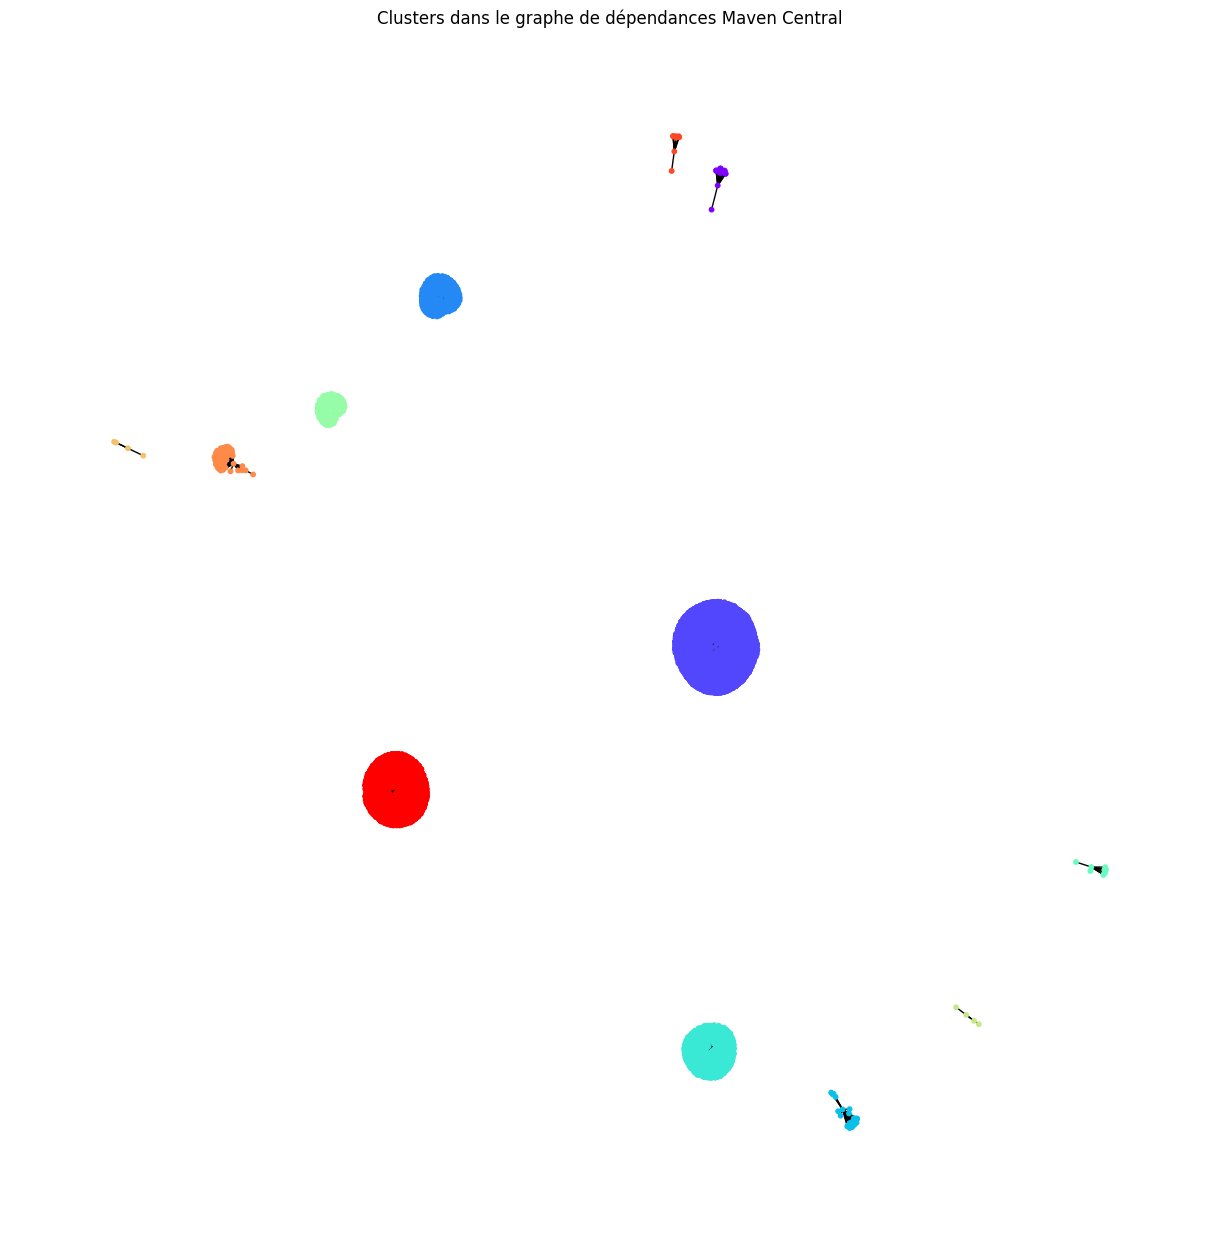

In [27]:
pos = nx.spring_layout(G)
cluster_colors = [G.nodes[node]["cluster"] for node in G.nodes]

plt.figure(figsize=(12, 12))
nx.draw(
    G,
    pos,
    node_color=cluster_colors,
    with_labels=False,
    node_size=10,
    cmap=plt.cm.rainbow
)
plt.title("Clusters dans le graphe de dépendances Maven Central")
plt.show()


#### Analyser les différents cluster 

#### Analyser leurs intéractions

#### Identifier les clusters à risque (utiliser les added_value de goblin)

#### En déduire comment le clustering peut aider à identifier les risques 